# MF-DMA (Multifractal Detrended Moving Average) Module

Reference:

Gu, Gao-Feng Gu, and Wei-Xing Zhou. "Detrending moving average algorithm for multifractals." Physical Review E, no. 82, 2010, pp. 011136,

Arianos, Sergio, and Anna Carbone. "Detrending moving average algorithm: A closed-form approximation of the scaling law." Physica A, no. 382, 2007, pp. 9–15,

Wang, Yudong, et al. “Multifractal Detrending Moving Average Analysis on The US Dollar Exchange Rates.” Physica A, no. 390, 2011, pp. 3512–3523.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
files = 'https://raw.githubusercontent.com/y3kiys4/wqu_capstone_june2023_grp3626/main/SPX_1m_Dec2020_Jun2023.csv'

df = pd.read_csv(files)
# Set timestamp as index
df = df.set_index(df['Time'])
df.drop(['Time'], axis=1, inplace=True)
df.index = pd.to_datetime(df.index)

# Calculate log return
df['log_ret'] = 10000 * np.log(df.Price).diff() # 10,000 times log return

# Calculate the time difference in mininutes
df['deltaT'] = (df.index.to_series().diff().dt.days.mul(60*24, fill_value=0) +
                df.index.to_series().diff().dt.seconds.div(60, fill_value=0)
               )

df_1min = df[df['deltaT'] == 1]
df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])
df_1min

C:\Users\cutef\AppData\Local\Temp\ipykernel_9124\374198705.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])


,Price,log_ret,deltaT,log_ret_sq
Time,,,,
2020-12-01 00:01:00,3654.045,1.932292,1.0,3.733753
2020-12-01 00:02:00,3654.336,0.796346,1.0,0.634167
2020-12-01 00:03:00,3653.945,-1.070019,1.0,1.144941
2020-12-01 00:04:00,3653.845,-0.273681,1.0,0.074901
2020-12-01 00:05:00,3653.299,-1.494428,1.0,2.233315
...,...,...,...,...
2023-06-30 16:09:00,4446.311,-1.171689,1.0,1.372856
2023-06-30 16:10:00,4445.570,-1.666689,1.0,2.777852
2023-06-30 16:11:00,4445.332,-0.535379,1.0,0.286630


## 1. Construct the sequence of cumulative sums

<AxesSubplot:xlabel='Time'>

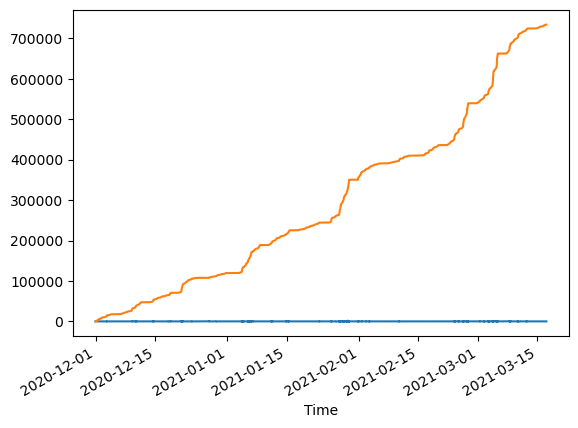

In [3]:
n_sample = 60 * 24 * 22 * 3 # sample is 3-month-equivalent dataset

cs = pd.DataFrame(df_1min['log_ret_sq'][:n_sample], columns = ['log_ret_sq'])
cs['cum_sum'] = cs['log_ret_sq']
cs['cum_sum'] = cs['cum_sum'].cumsum()

cs['log_ret_sq'].plot()
cs['cum_sum'].plot()

In [4]:
cs

,log_ret_sq,cum_sum
Time,,
2020-12-01 00:01:00,3.733753,3.733753
2020-12-01 00:02:00,0.634167,4.367920
2020-12-01 00:03:00,1.144941,5.512860
2020-12-01 00:04:00,0.074901,5.587761
2020-12-01 00:05:00,2.233315,7.821076
...,...,...
2021-03-17 02:25:00,1.518706,734155.463935
2021-03-17 02:26:00,0.286569,734155.750504
2021-03-17 02:27:00,0.573778,734156.324282


## In the for-loop:
### 2. Calculate moving average
### 3. Detrend
### 4. Define non-overlapping segments and calculate each fluctuation variance
### 5. Calculate q-th order fluctuation function

In [5]:
# Define parameters
lags = np.unique(np.logspace(0.5, 3, 50).astype(int))
qs = list(np.linspace(-10, 10, num=41, endpoint=True)) # q is in [-10, 10] excluding 0
total_epoch = len(lags) * len(qs)
len_total = len(cs['cum_sum'])

# Create DMA flucuation function dataframe
F_summary_columns = []
for q in qs:
    F_summary_columns.append('q_'+str(q))

F_summary_index = []
for l in lags:
    F_summary_index.append('n_'+str(l))

F_summary = pd.DataFrame(index=F_summary_index, columns=F_summary_columns)

In [6]:
print(f'Total epochs is {total_epoch}')
starttime_total = time.time()

epoch = 0
for lag in lags:
    mean_temp = []
    # Calculate moving average
    for i in range(len(cs['cum_sum'])-lag+1):
        mean_temp.append(np.mean(cs['cum_sum'][i:i+lag]))
    mean_temp.reverse()

    # Detrend
    diff_temp_subtractor = cs['cum_sum'][:lag-2:-1].values
    diff_temp = np.subtract(np.array(mean_temp), diff_temp_subtractor)

    # Slice into non-overlapping segments
    segs_temp = pd.DataFrame(np.resize(diff_temp, (len(diff_temp) // lag, lag))).T

    # Calculate fluctuation variance
    F_seg_sq_temp = np.array(np.var(segs_temp).mean(axis=0)) 

    for q in qs:
        # Calculate the qth order fluctuation function
        if q != 0.0:
            F_temp =  ((1 / lag) * (F_seg_sq_temp ** (q / 2)).sum()) ** (1 / q)
        else:
            F_temp = np.exp(np.log(F_seg_sq_temp ** (1 / 2)).mean()) # L’Hôspital’s rule when q = 0
        F_summary.loc[str('n_'+str(lag))][str('q_'+str(q))] = F_temp
        epoch += 1
        
    print(f'Epoch {epoch} is done')
        
endtime_total = time.time()        
total_time = endtime_total - starttime_total
print(f'Total time spent is {int((endtime_total-starttime_total)//60)} min {int((endtime_total-starttime_total) % 60)} sec(s)')

Total epochs is 1927
Epoch 41 is done
Epoch 82 is done
Epoch 123 is done
Epoch 164 is done
Epoch 205 is done
Epoch 246 is done
Epoch 287 is done
Epoch 328 is done
Epoch 369 is done
Epoch 410 is done
Epoch 451 is done
Epoch 492 is done
Epoch 533 is done
Epoch 574 is done
Epoch 615 is done
Epoch 656 is done
Epoch 697 is done
Epoch 738 is done
Epoch 779 is done
Epoch 820 is done
Epoch 861 is done
Epoch 902 is done
Epoch 943 is done
Epoch 984 is done
Epoch 1025 is done
Epoch 1066 is done
Epoch 1107 is done
Epoch 1148 is done
Epoch 1189 is done
Epoch 1230 is done
Epoch 1271 is done
Epoch 1312 is done
Epoch 1353 is done
Epoch 1394 is done
Epoch 1435 is done
Epoch 1476 is done
Epoch 1517 is done
Epoch 1558 is done
Epoch 1599 is done
Epoch 1640 is done
Epoch 1681 is done
Epoch 1722 is done
Epoch 1763 is done
Epoch 1804 is done
Epoch 1845 is done
Epoch 1886 is done
Epoch 1927 is done
Total time spent is 9 min 33 sec(s)


In [7]:
F_summary

,q_-10.0,q_-9.5,q_-9.0,q_-8.5,q_-8.0,q_-7.5,q_-7.0,q_-6.5,q_-6.0,q_-5.5,...,q_5.5,q_6.0,q_6.5,q_7.0,q_7.5,q_8.0,q_8.5,q_9.0,q_9.5,q_10.0
n_3,15.671339,15.762216,15.863808,15.978128,16.107723,16.255867,16.426845,16.626363,16.862198,17.145229,...,11.498592,11.691595,11.857434,12.001452,12.127682,12.239222,12.338492,12.427407,12.507505,12.580035
n_4,20.414658,20.564154,20.731545,20.920241,21.134579,21.380151,21.664301,21.996861,22.391307,22.866598,...,13.812448,14.105639,14.35858,14.578993,14.772753,14.944404,15.097517,15.234933,15.358944,15.471418
n_5,24.242208,24.448429,24.679622,24.940602,25.237505,25.57827,25.973353,26.436808,26.987967,27.654169,...,15.402447,15.782659,16.111698,16.399187,16.652489,16.877337,17.078251,17.258849,17.422055,17.570259
n_6,27.049781,27.306076,27.593697,27.918742,28.288996,28.714558,29.208758,29.789568,30.481793,31.320644,...,16.325504,16.774777,17.164575,17.505889,17.807179,18.075059,18.314768,18.53051,18.725696,18.903121
n_7,30.207282,30.518244,30.867513,31.262604,31.71313,32.23158,32.83448,33.544161,34.391532,35.42061,...,17.456118,17.978447,18.432607,18.831008,19.183247,19.496857,19.777826,20.030974,20.26022,20.468784
n_8,33.143177,33.507902,33.917862,34.38199,34.911731,35.521977,36.232474,37.069955,38.071513,39.290116,...,18.445352,19.035756,19.550065,20.001947,20.402018,20.758639,21.078478,21.366914,21.628332,21.866342
n_9,37.044903,37.47579,37.960433,38.509514,39.136729,39.859932,40.702827,41.697571,42.888873,44.340731,...,19.943693,20.61882,21.2079,21.726204,22.185636,22.595601,22.963622,23.295781,23.597046,23.871514
n_10,39.063572,39.539859,40.07588,40.683566,41.378235,42.179875,43.11507,44.219936,45.544782,47.161775,...,20.415206,21.140015,21.773378,22.331342,22.826463,23.268691,23.666002,24.024859,24.350551,24.647448
n_11,43.68249,44.237279,44.861978,45.570617,46.381224,47.317357,48.410382,49.702975,51.254685,53.151099,...,22.224091,23.046378,23.765878,24.400445,24.964091,25.467953,25.920975,26.330422,26.702249,27.04138
n_12,45.483257,46.082014,46.75655,47.522133,48.398409,49.41107,50.594368,51.994968,53.678079,55.737592,...,22.579725,23.446061,24.205025,24.875091,25.470801,26.003737,26.483229,26.91686,27.310862,27.670391


## 6. Calculate Hurst exponent

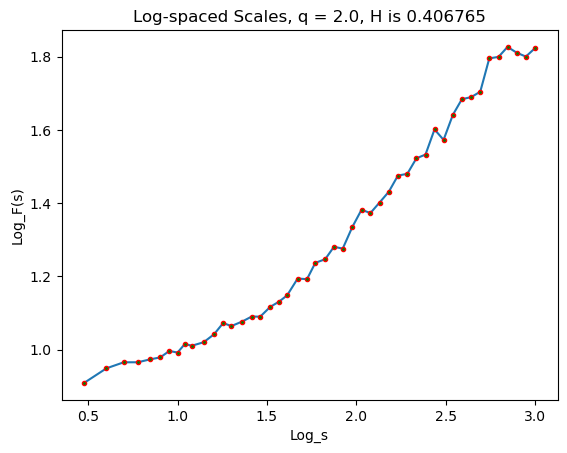

In [8]:
# Log-log plot and calculate H
log10_lag = np.log10(lags)
log10_F = np.log10(np.array(F_summary['q_2.0']).astype(float)) 
hurst_hat = np.polyfit(log10_lag, log10_F, 1)[0]

plt.plot(log10_lag, log10_F, marker="o", markersize=3, markeredgecolor="red", markerfacecolor="green") 
plt.xlabel('Log_s')
plt.ylabel('Log_F(s)')
plt.title('Log-spaced Scales, q = 2.0, H is '+ f'{hurst_hat:2f}')
plt.show()

## 7. $\tau(q)=qh(q)-1$

In [14]:
hurst_hat_q = np.polyfit(np.log10(lags), np.log10(np.array(F_summary).astype(float)) , 1)[0]
tau_q = np.subtract(np.multiply(qs, hurst_hat_q), np.array([1] * len(qs)))

tau_q_h = pd.DataFrame()
tau_q_h['tau'] = tau_q
tau_q_h['q'] = qs
tau_q_h['h'] = hurst_hat_q

tau_q_h

,tau,q,h
0,-11.067650,-10.0,1.006765
1,-10.614267,-9.5,1.012028
2,-10.160885,-9.0,1.017876
3,-9.707502,-8.5,1.024412
4,-9.254120,-8.0,1.031765
5,-8.800737,-7.5,1.040098
6,-8.347355,-7.0,1.049622
7,-7.893972,-6.5,1.060611
8,-7.440590,-6.0,1.073432
9,-6.987207,-5.5,1.088583


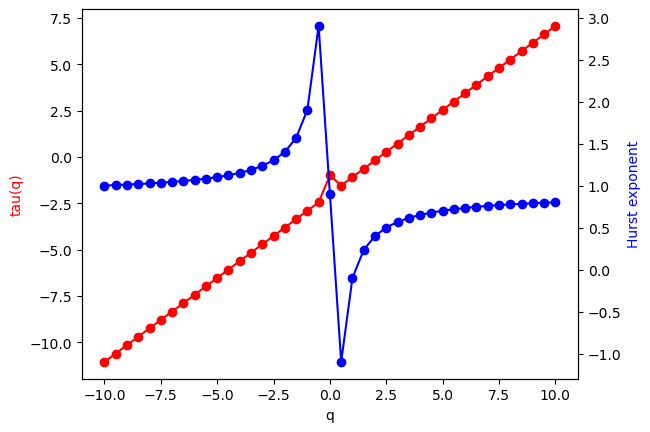

In [34]:
# plt.plot(tau_q_h['q'],tau_q_h['tau'], label='q - tau plot')
# plt.plot(tau_q_h['q'],tau_q_h['h'], label='q - hurst plot')
# plt.legend()
# plt.xlabel('q')
# plt.show()

fig,ax = plt.subplots()

ax.plot(tau_q_h['q'], tau_q_h['tau'], marker='o', color='r')
ax.set_xlabel('q')
# set y-axis label
ax.set_ylabel('tau(q)', color='r')
ax2=ax.twinx()
ax2.plot(tau_q_h['q'], tau_q_h['h'], marker='o', color='b')
ax2.set_ylabel('Hurst exponent', color='b')
plt.show()

## 8. Legendre transform